In [1]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=5371ddffc926ef28c2a9a0737e2216ffe34a72c18c18d133bfe053d7a7f7942d
  Stored in directory: /root/.cache/pip/wheels/f0/3f/76/8783033e8524d407e1bebaf72fdd3f3eba27e0c030e92bbd87
Successfully built chess


In [ ]:
# might need this for linux
!chmod +x /content/stockfish

Dependencies

In [ ]:
import chess
import chess.engine
import random
import numpy as np

Step 1: Getting Dataset

In [ ]:
def generate_random_game(max_depth = 300):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    legal_moves = list(board.legal_moves)
    move = random.choice(legal_moves)
    board.push(move)

    #break if game ended
    if board.is_game_over():
      break


  return board

In [ ]:
def get_engine(engine_path):
  engine = chess.engine.SimpleEngine.popen_uci(engine_path)
  return engine

In [9]:
# returns numerial evaluation of a board with respect to a depth
def get_engine_eval(board, depth):
  with chess.engine.SimpleEngine.popen_uci('stockfish.exe') as engine:
    result = engine.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

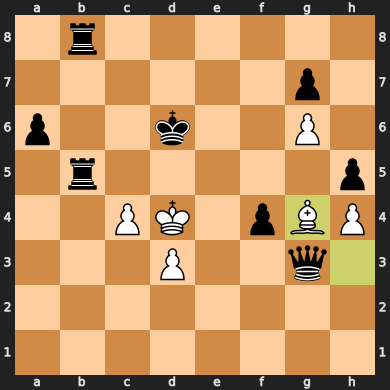

In [52]:
board = generate_random_game(500)
board

In [ ]:
get_engine_eval(board, 3, get_engine('/content/stockfish'))

In [ ]:
def parse_board(board):

  # for now ... we can generate multiple 2d arrays of the board to represent aspects of the game
  # such as, where the black and white pieces are, how many of certain pieces exist, what squares are being attacked ... more to be potentially added

  piece_types = [
      (chess.WHITE, chess.PAWN),
      (chess.WHITE, chess.KNIGHT),
      (chess.WHITE, chess.BISHOP),
      (chess.WHITE, chess.ROOK),
      (chess.WHITE, chess.QUEEN),
      (chess.WHITE, chess.KING),
      (chess.BLACK, chess.PAWN),
      (chess.BLACK, chess.KNIGHT),
      (chess.BLACK, chess.BISHOP),
      (chess.BLACK, chess.ROOK),
      (chess.BLACK, chess.QUEEN),
      (chess.BLACK, chess.KING),

      #empty placeholders for attacked squares from black and white
      (chess.WHITE, None),
      (chess.BLACK, None),
  ]


  # 12 for piece_types, 2 for squares white and black are attacking
  piece_arrays = np.zeros((14, 8, 8))

  for i, (color, piece_type) in enumerate(piece_types):

      # handling attacked squared seperatly
      if piece_type is None:

        # puts a square into a list if its attack by the current color
        attacked_squares = [ sq for sq in chess.SQUARES if board.is_attacked_by(color, sq) ]
        rows = [7 - (sq // 8) for sq in attacked_squares]
        cols = [sq % 8 for sq in attacked_squares]
        piece_arrays[i][rows, cols] = 1

      else:
        # returns indices of piece positions
        squares = list(board.pieces(piece_type, color))

        rows = [7 - (sq // 8) for sq in squares]
        cols = [sq % 8 for sq in squares]

        piece_arrays[i][rows, cols] = 1



  return piece_arrays



In [ ]:
parse_board(board)

In [ ]:
def generate_data(num_games, depth):

    board_data = []  #  holds the board + evaluation as 3D matrix
    eval_data = []   # holds just the evaluation score for supervised learing

    stockfish = get_engine('/content/stockfish')

    i = 0
    progress = 0

    print("Generating Data")

    while i < num_games:

        board = generate_random_game()
        eval_score = get_engine_eval(board, depth, stockfish)

        if eval_score is None or np.isnan(float(eval_score)):
          continue

        parsed_board = parse_board(board)
        board_data.append(parsed_board)
        eval_data.append(eval_score)

        eval_score = float(eval_score)

        if i == int(num_games * progress):
          print(f"{progress * 100}%")
          progress += .25


        i += 1

    print("100%")

    board_data = np.array(board_data, dtype=np.float32)
    eval_data = np.array(eval_data, dtype=np.float32)

    print(board_data.shape)  #  (num_games, 15, 8, 8)
    print(eval_data.shape)   #  (num_games, 1)

    np.save("boards", board_data)
    np.save("evals", eval_data)



In [ ]:
generate_data(15000, 10)

In [ ]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as utils

In [ ]:

def make_model(conv_depth, conv_size):

  model = models.Sequential()

  model.add(layers.InputLayer(shape=(14,8,8)))


  for _ in range(conv_depth):
    model.add(layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
model = make_model(3, 32)
model.summary()

In [ ]:
# for validation and testing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


def train_model(board_file, eval_file, conv_depth, conv_size, batch_size=32, epochs=10):
    X_train = np.load(board_file)
    Y_train = np.load(eval_file)

    X_train = np.array(X_train, dtype=np.float32)
    Y_train = np.array(Y_train / np.abs(Y_train).max() / 2 + 0.5, dtype=np.float32)

    if np.isnan(Y_train).any():
      print("NaN values found after loading!")

    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

    model = make_model(conv_depth, conv_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    model.compile(
        optimizer= 'adam',
        loss='mean_squared_error',
        metrics=['mae'],
    )


    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, Y_test), callbacks=[early_stopping, model_checkpoint] )


In [ ]:
train_model(board_file='boards.npy', eval_file='evals.npy', conv_depth=3, conv_size=32, batch_size=512, epochs=1000)